# Pytinent Gen
## Creating Maps
The goal of this project is to use procedural techniques to generate terrain data, to be used to create visuals of landscapes, or serve as the basis for a videogame. All of the code used will be displayed inline here, and will feature some visualizations and explanations to aid in the understanding of the process. This is currently a very rough work in progress, so bear with me.

## Perlin Noise
Perlin Noise is an important component of many procedural algorithms, valued for it's ability to create wave-like noise that, while seemingly random, approximates natural patterns. Unlike pure random noise, where every sample is completely random, in perlin noise a sample is more likely to be close to it's neigbour.

Below is an implementation of Ken Perlin's 2002 update to perlin noise seen at http://mrl.nyu.edu/~perlin/noise/

**If the code is unfamiliar and/or intimidating just scroll down! The explanation is below and doesn't require specific knowledge of the code being used**

In [1]:
#----- INIT IMPORTS AND SETUP -----
#----- Visualization -----
from IPython.core import page
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
page.page = print 
# --- Analysis Packages ---
import pandas as pd
import numpy as np
import pylab
import matplotlib.pyplot as plt
#----- My Files -----
import perlin
import geometry

In [2]:
%pycat perlin.py

import numpy as np
#Evil Globals
permutation = None
gradients = None

#----- PUBLIC PERLIN MAP FUNCTIONS -----
def perlin_map(x_size,y_size,scale,as_list=False,normalize = False):
    """Returns a perlin map of size x * y. Scale will adjust fineness of noise"""
    linx = np.linspace(0,scale,x_size)
    liny = np.linspace(0,scale,y_size)
    x,y = np.meshgrid(linx,liny)
    map = __perlin(x,y)
    if normalize:
        map -= map.min()
        map /= map.max()
    if as_list:
        return map.tolist()
    return map

def octave_map(x_size,y_size,num_octaves,base_scale,as_list=False,normalize = False):
    """Returns a map of the sum of num_octaves perlin maps, each scaled down in amplitude by 1/n"""
    output = np.zeros((x_size,y_size))
    for n in range(1,num_octaves+1):
        output += perlin_map(x_size,y_size,base_scale*n)*(1/n)
    if normalize:
        output -= output.min()
        output /= output.max()
    return output

#----- PERMUTATION AND GRADIENT FUNCTIONS -----
#Si

**NOTE: Perlin noise is implemented in many standard libraries, Python included.** I simply wanted to write the album for my own curiosity, thanks in no small part to this wonderful writeup by Adrian Biagioli: http://flafla2.github.io/2014/08/09/perlinnoise.html 

There is no need to reinvent the wheel and write your own perlin algorithm. Simply understanding what the noise looks like, and how it can be manipulated is more than enough. Disclaimers aside... **Let's see what our perlin noise looks like:**

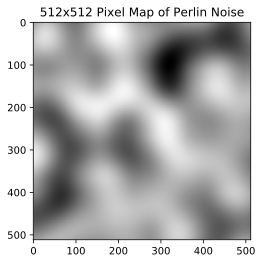

In [3]:
MAP_SIZE = 512
map = perlin.perlin_map(MAP_SIZE,MAP_SIZE,4)
plt.rcParams['image.cmap'] = 'gray'
plt.title("512x512 Pixel Map of Perlin Noise")
plt.imshow(map)
pylab.show()

**By scaling the inputs we can create various grades of noise:**

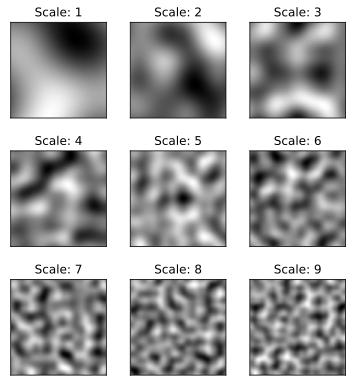

In [4]:
plt.figure(1)
for n in range(1,10):
    map = perlin.perlin_map(MAP_SIZE,MAP_SIZE,n)
    plt.subplot(3,3,n)
    plt.title("Scale: "+str(n))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(map) 
plt.subplots_adjust(hspace=0.25, wspace=0.25,top=2,bottom=0.75)

**Instead of using greyscale, let's switch the color scheme over to pyplot's handy "terrain" color scheme:**

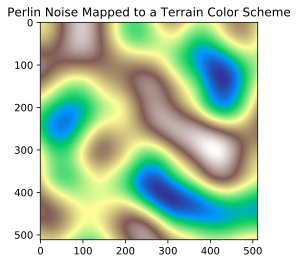

In [5]:
plt.rcParams['image.cmap'] = 'terrain'
plt.title("Perlin Noise Mapped to a Terrain Color Scheme")
plt.imshow(perlin.perlin_map(MAP_SIZE,MAP_SIZE,3))
None

## Octaves

**This image is nice, but the contour can be improved** by beginning with a low scale and layering on higher scale images on top. By assigning these different "octaves" successively lower weights, we can get a fractal-like pattern that looks much better than a single pass of perlin noise:

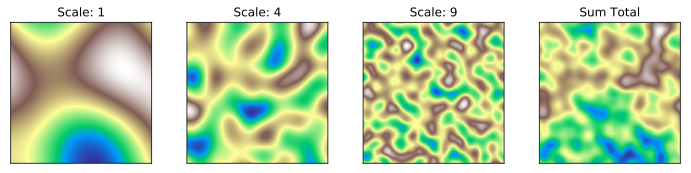

In [6]:
plt.figure(figsize=(12,15))
sum_map = np.zeros((MAP_SIZE,MAP_SIZE))
#This feature is in the perlin.py file as octave_map()
for n in range(1,4):
    map = perlin.perlin_map(MAP_SIZE,MAP_SIZE,(n)*n) * (1/n) #weight of each map is 1/n
    sum_map += map
    plt.subplot(1,4,n)
    plt.title("Scale: "+str((n)*n))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(map)     
plt.subplot(1,4,4)
plt.imshow(sum_map)
plt.title("Sum Total")
plt.xticks([])
plt.yticks([])
plt.subplots_adjust(hspace=0.25, wspace=0.25,top=2,bottom=0.5)
None


Looking more closely at the final product many of the unseemly lines and bare geometry of the original noise passes have given way to a very natural looking terrain:

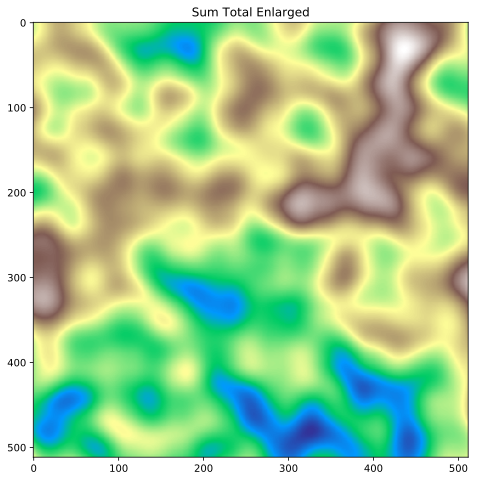

In [7]:
plt.figure(figsize = (30,8))
plt.imshow(sum_map)
plt.title("Sum Total Enlarged")
None

Experimenting with different scales and weights for the noise function will allow for even more control of the terrain's final look. 

**For now we will settle on some arbitrary values** to use that reflect the rough size of our desired terrain:

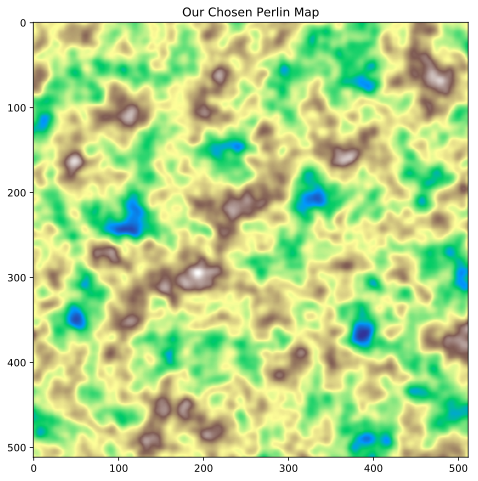

In [8]:
NUM_OCTAVES = 6
BASE_SCALE = 6
map = perlin.octave_map(MAP_SIZE,MAP_SIZE,NUM_OCTAVES,BASE_SCALE,normalize=True)
plt.figure(figsize = (30,8))
plt.imshow(map)
plt.title("Our Chosen Perlin Map")
None

# Creating a Coastline
This is great for a landlocked section of a map, but without any real borders, it just looks like a small snapshot of a full map. What we want is for our map to be surrounded by water, like a real continent. Knowing that water is represented by a value of 0 (actually, our map hasn't been normalized yet and is still from -0.5 to .5, but we will be fixing that in a moment) the most logical first idea is:

**Let's try multiplying the whole map by a circle** whose values decrease from the center to the edge:

In [9]:
%pycat geometry.py

import numpy as np
def normalize(array):
    """Normalizes an array to contain floats from [0,1]"""
    array -= array.min()
    array /= array.max()
    return array

def circle(size,r):
    """Returns an array of floats with an inscribed circle of size r where the center is 1.0 and edges are 0"""
    center = size//2
    maxdist = np.sqrt(2*(center**2))
    x,y = np.indices((size,size))
    array = (1-np.abs(np.hypot(x-center,y-center)/r))
    return array.clip(min=0)



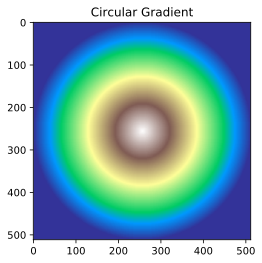

In [10]:
#Create a circle map with a radius the size of the whole map
circ = geometry.circle(MAP_SIZE,MAP_SIZE/2)
plt.imshow(circ)
plt.title("Circular Gradient")
None

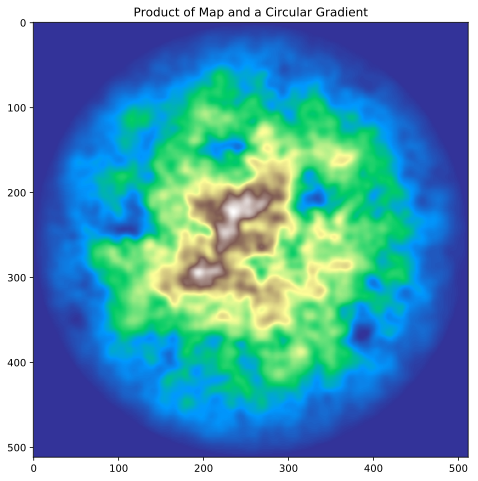

In [11]:
#Use normalize to get the main map from 0-1 values
geometry.normalize(map)
#Plot the product of the two
plt.figure(figsize = (30,8))
plt.title("Product of Map and a Circular Gradient")
plt.imshow(circ*map)
None

**This is better but it's still pretty bad** the circle itself is glaringly obvious and round, and because the circle values descended from the center of the circle, the whole thing ends up being shaped like a volcanic island, with all the highest peaks in the middle. A real continent is much more dynamic. 

**Let's start by making the overall shape less circular.** To do this we'll multiply the whole circle by a very coarse perlin map to get a kind of misshapen blob

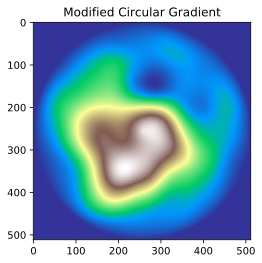

In [12]:
CIRCLE_MUTATOR_OCTAVES = 2
CIRCLE_MUTATOR_BASE_SCALE = 2
circle_mutator = geometry.normalize(perlin.octave_map(MAP_SIZE,MAP_SIZE,CIRCLE_MUTATOR_OCTAVES,CIRCLE_MUTATOR_BASE_SCALE))
circ = circ * circle_mutator
plt.imshow(circ)
plt.title("Modified Circular Gradient")
None

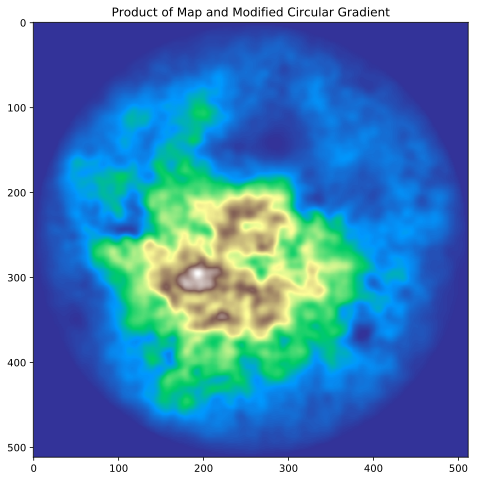

In [13]:
#Plot the product of the two
plt.figure(figsize = (30,8))
plt.title("Product of Map and Modified Circular Gradient")
plt.imshow(circ*map)
None

**This is better but the whole shape still tends to the middle** What we really want is for only the coastal edges to descend to the water, but every other point to be what it was in the original map.


**Let's turn the circle into a plateau:** We'll take all the values above a certain cutoff and simply jump them to 1. In order for the transition areas to evenly ascend to this cutoff point 

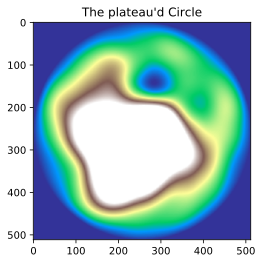

In [14]:
def plateau(array, cutoff):
    """Takes all values above cutoff and elimates them, making all values from [0-cutoff] scale from [0-1]"""
    return geometry.normalize(array.clip(max=cutoff))
circ = plateau(circ,0.25)
plt.imshow(circ)
plt.title("The plateau'd Circle")
None

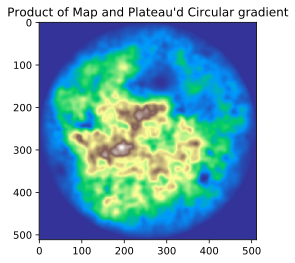

In [15]:
plt.imshow(circ*map)
plt.title("Product of Map and Plateau'd Circular gradient")
None